### First we generate an SDE

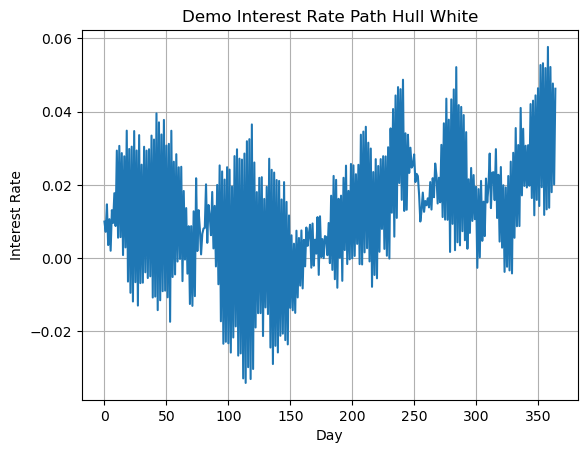

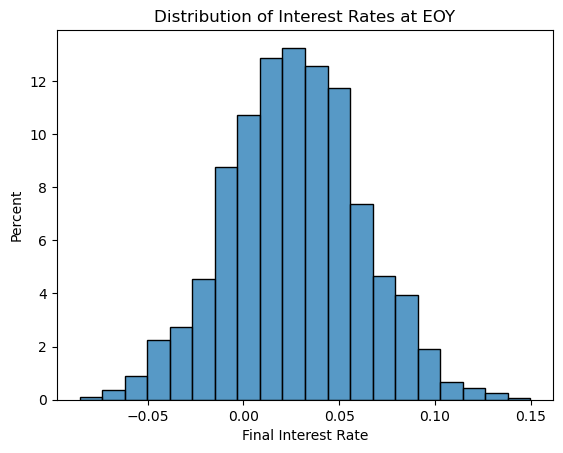

In [1]:
from numpy.random import normal as normal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from random import choices as draw
from itertools import chain

## Hull White Model
theta = 0.03 # Stasis rate 3%
alpha = 4 # Juiced Return Rate
sigma = 0.1
dt = 1/365 # Daily updates

hw = lambda r: r + alpha*(theta - r)*dt + sigma*np.sqrt(dt)*normal()
r0 = 0.01 # Initial interest rate of 1% means that we will see an expected drift up

rs = [r0]
for i in range(364):
    rs.append(hw(rs[i-1]))

plt.plot(rs)
plt.title('Demo Interest Rate Path Hull White')
plt.ylabel('Interest Rate')
plt.xlabel('Day')
plt.grid()
plt.show()

## Generate 2000 paths for an empirical set of end points
def generatePath():
    rs = [r0]
    for i in range(364):
        rs.append(hw(rs[i-1]))
    return rs

paths = [generatePath() for i in range(2000)]
end_data = [path[-1] for path in paths]
sb.histplot(end_data, bins = 20, stat = 'percent');
plt.xlabel('Final Interest Rate');
plt.title('Distribution of Interest Rates at EOY');
plt.show()

In [ ]:
'''
I choose to use two models in this fit, one forwardwise model, which will replicate the Hull-White Structure, and hopefully recover the correct parameters,
and one reversewise flexible Neural Network to handle the nonlinearities and time dependence in the structure.
'''

# Forward Model,
# We maximise the likelihood by fitting a Hull White model, this can be done by least squares
def leastSquares(x: np.matrix, y:np.matrix):
    return np.linalg.inv(x.T@x)@x.T@y

def regressHullWhite(data: list[np.matrix], dt:float = 1/365):
    # We treat the (discretized) Hull-White model as:
    # r_t+1 = alpha*(theta - r_t)dt + sigma*sqrt(dt)*N(0,1) -> 
    # a*r + b + eps = y         | a = -alpha*dt, b = alpha*theta*dt, eps = N(0,(sigma**2)*dt)
    # We can regress a and b, and given a known dt estimate out alpha, theta and sigma
    x_list = [entry[:-1] for entry in data]
    y_list = [np.diff(entry) for entry in data]

    x = np.asmatrix(list(chain.from_iterable(x_list)))
    x = np.asmatrix(np.concat([x,np.ones_like(x)])).T
    y = np.asmatrix(list(chain.from_iterable(y_list))).T

    beta = leastSquares(x,y)
    a = beta[0,0] # ax + b = y
    b = beta[1,0]
    sigma_obs = np.std(y - b - a*x)

    alpha = -a/dt
    theta = b/(alpha*dt)
    sigma = sigma_obs/np.sqrt(dt)

    return alpha, theta #, sigma

def generateHullWhite(r0s, alpha, theta, sigma, N):
    # Generates a Hull White Path starting at 0 and ending 1 from params
    t_s = np.arange(N)/(N-1)
    dt = t_s[1]-t_s[0]
    
    r_s = []
    for r in r0s:
        rs = [r0]
        for i, t in enumerate(t_s[1:]):
            rs.append(rs[i] + alpha*(theta - rs[i])*dt + sigma*np.sqrt(dt)*normal())
        r_s.append(rs)
        
    return r_s, dt


# Backwards Model
# Since the backwards model needs to handle time dependence and the nonlinearity of the reversed process we make this a simple neural network, looking at the last point and the time
import torch as th
from torch.utils.data import Dataset, DataLoader, RandomSampler
class HWDataSet(Dataset):
    def __init__(self, inputPaths):
        x_list = [entry[:-1] for entry in inputPaths]
        time_encoding = [np.arange(len(entry)-1)/(len(entry)-1) for entry in inputPaths] # Very naive time encoding, normalized
        y_list = [np.diff(entry) for entry in inputPaths]

        x = np.asmatrix(list(chain.from_iterable(x_list)))
        self.ExtX = [np.max(x), np.min(x)]
        t = (np.asmatrix(list(chain.from_iterable(time_encoding)))-0.5)*2
        x = np.concat([x,t]).T
        y = np.asmatrix(list(chain.from_iterable(y_list))).T
        self.ExtY = [np.max(y), np.min(y)]

        self.x = th.tensor(x, dtype=th.float32)
        self.y = th.tensor(y, dtype=th.float32)

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def getEx(self):
        return {'x':self.ExtX, 'y':self.ExtY}

class backwardsModel(th.nn.Module):
    def __init__(self, dim = 100):
        super().__init__()
        self.dim = dim
        self.inputDim = 2
        self.outputDim = 1
        self.learning_rate = 1e-3
        self.ex = {'x':[0.0,0.0], 'y':[0.00,0.00]}   # Track highest/lowest input and target
        self.setup()

    def setup(self):
        self.predictor = th.nn.Sequential(
            th.nn.Linear(self.inputDim, self.dim),
            th.nn.Linear(self.dim, round(self.dim/2)),
            th.nn.LeakyReLU(),
            th.nn.Linear(round(self.dim/2), round(self.dim/4)),
            th.nn.LeakyReLU(),
            th.nn.Linear(round(self.dim/4), round(self.dim/8)),
            th.nn.LeakyReLU(),
            th.nn.Linear(round(self.dim/8), self.outputDim),
        )

    def forward(self, x):
        x = self.predictor(x)
        return x

    def normalize(self, vec:np.matrix, type:str = 'x'):
        extremes = self.ex[type]
        diff = extremes[0]-extremes[1]
        if diff > 1e-4:
            vec[:,0] = 2*(vec[:,0] - extremes[1])/diff - 1.0 # type: ignore \\ If the extremes are distinct map to [1,-1] where 1 is representation of highest before seen
        else:
            vec[:,0] = vec[:,0] - (extremes[0]+extremes[1])/2 # type: ignore \\ If the two are very close, simply offset to be zero centered
        return vec
    
    def denormalize(self, vec:np.matrix, type:str = 'x'):
        extremes = self.ex[type]
        diff = extremes[0]-extremes[1]
        if diff > 1e-4:
            vec = diff*(vec + 1)/2 + extremes[1] # type: ignore \\ If the extremes are distinct map to [extreme,-extreme] where 1 is representation of highest before seen
        else:
            vec = vec + (extremes[0]+extremes[1])/2 # type: ignore \\ If the two are very close, simply offset to be zero centered
        return vec

    @staticmethod
    def l4_loss(pred, target):
        return th.mean((pred - target)**4)

    def fit(self, inputPaths, epochs = 32, batch_size = 64, frozenTransform = False):
        self.train()
        dataset =  HWDataSet(inputPaths)
        if not frozenTransform:
            newEx = dataset.getEx()
            self.ex['x'] = [max(self.ex['x'][0],newEx['x'][0]), min(self.ex['x'][1],newEx['x'][1])]
            self.ex['y'] = [max(self.ex['y'][0],newEx['y'][0]), min(self.ex['y'][1],newEx['y'][1])]
        
        sampler = RandomSampler(dataset, replacement=True)
        loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

        loss_fn = th.nn.MSELoss()
        
        optimizer = th.optim.Adam(self.parameters(), lr=self.learning_rate) # ADAM might fit too fast / overfit / find extremely steep or unstable minima in weight space.
                                                                            # Previous runs with ADAM do show much faster initial finding of the correct properties, though stagnation occurs
        for epoch in np.arange(epochs):
            for xb, yb in loader:
                xb, yb = self.normalize(xb,'x'), self.normalize(yb,'y')           
                optimizer.zero_grad()
                pred = self(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()
            #print(f"epoch {epoch}, loss={loss.item():.4f}")
   
    @th.no_grad()
    def predict(self, X_np):
        self.eval()
        X_tensor = th.tensor(self.normalize(X_np), dtype=th.float32)
        preds = self(X_tensor)
        return self.denormalize(preds.cpu().numpy().item(), type='y')
    
    @th.no_grad()
    def generatePaths(self, r0s, N):
        t_s = np.arange(N)/(N-1)
        dt = t_s[1]
        r_s = []
        for r0 in r0s:
            rs = [r0]
            for i, t in enumerate(t_s[:-1]):
                rs.append(np.squeeze(rs[i] + self.predict(np.asmatrix([rs[i],t]))) + sigma*np.sqrt(dt)*normal())
            r_s.append(rs)
        return r_s


In [30]:
## Now we Drop The Pathwise info completely
paths.clear()
frames = {'start': [r0], 'end': end_data}


alpha_init = 1
theta_init = 1

alphas = [alpha_init]
thetas = [theta_init]
backModel = backwardsModel()

numSamples = 500
schrodSteps = 25
for i in range(1,schrodSteps+1):
    forwardPaths, dt = generateHullWhite(draw(frames['start'], k=numSamples), alphas[i-1], thetas[i-1], sigma, N=15)
    backModel.fit([path[::-1] for path in forwardPaths], frozenTransform = i*5 > schrodSteps)

    backwardsPaths = backModel.generatePaths(draw(frames['end'], k = numSamples), N = 15)
    alpha, theta = regressHullWhite([path[::-1] for path in backwardsPaths], dt)
    alphas.append(alpha)
    thetas.append(theta)
    print(f"{i}: {alpha}, {theta}")


1: 2.682698930341535, 0.044236989270729804
2: 4.97778290239379, 0.024422518303238213
3: 6.733230484391245, 0.024184674291997204
4: 7.838206449565612, 0.02294578472196397
5: 8.49106942032963, 0.023993193171438536
6: 9.010232717571734, 0.02189616455727598
7: 8.647218390951137, 0.020554894138737262
8: 7.9698504780027815, 0.018487569369834454
9: 8.403406357478817, 0.019606181097189417
10: 8.518998959421008, 0.01846985872294759
11: 9.662886027345197, 0.020198986422438264
12: 9.968557016554376, 0.02034306387007135
13: 10.591853014114614, 0.022264700103979167
14: 10.731351043831568, 0.0205361609446431
15: 10.227817445994614, 0.017514891578518797
16: 10.35080912164217, 0.017123972231520516
17: 10.7090592862526, 0.017472068437256526
18: 11.148581653053087, 0.016117371103306334
19: 11.737938374548394, 0.01695181069730711
20: 12.265412540375321, 0.016151780619779
21: 11.78339137864667, 0.013834454671385218
22: 11.675182651543254, 0.012933920969124888
23: 11.699176945110768, 0.01481944700551473
24

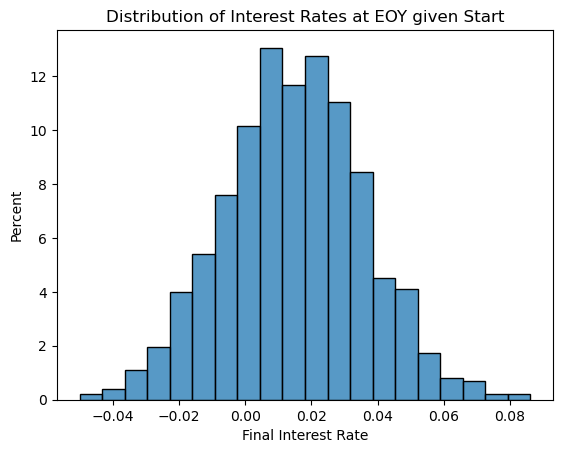

In [31]:
dummies, dt = generateHullWhite(draw(frames['start'], k=2000), alphas[i-1], thetas[i-1], sigma, N=100)
dend_data = [path[-1] for path in dummies]
sb.histplot(dend_data, bins = 20, stat = 'percent');
plt.xlabel('Final Interest Rate');
plt.title('Distribution of Interest Rates at EOY given Start');
plt.show()

[np.float64(0.07577272153794994), np.float64(0.016710741498564465), np.float64(0.011907635517351675), np.float64(-0.020344161911941168), np.float64(-0.003712411036518471), np.float64(0.011319410879725055), np.float64(0.009372583564851173), np.float64(0.01849239547371584), np.float64(0.027707278170145143), np.float64(0.013559126456434334), np.float64(0.015657114609563247), np.float64(0.0030378476422743515), np.float64(0.005769788465934481), np.float64(0.01208610626068267), np.float64(0.027263443514820927), np.float64(0.014564530291694962), np.float64(0.01370047910256432), np.float64(0.00017692325237382567), np.float64(0.006654150649365541), np.float64(0.01190929407490646), np.float64(0.021906512484397622), np.float64(0.0014453272415081205), np.float64(0.0264665949484761), np.float64(-0.0019304100994649992), np.float64(0.015335445415946853), np.float64(0.02848364838718509), np.float64(-0.005551632388800142), np.float64(0.01994878235853114), np.float64(0.007881626930029428), np.float64(-0

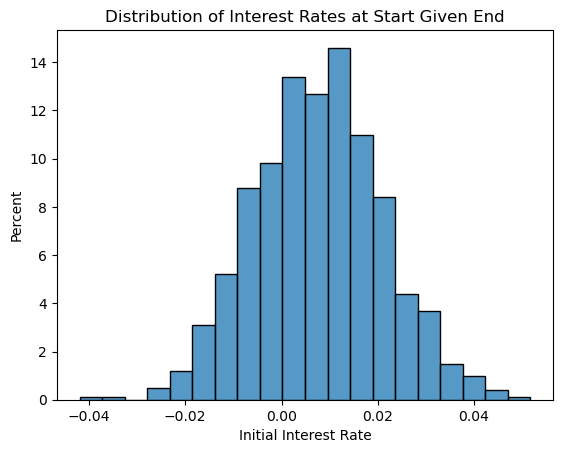

In [32]:
dummies = backModel.generatePaths(draw(frames['end'], k = 1000), N = 60)
print(dummies[0])
dend_data = [path[-1] for path in dummies]
sb.histplot(dend_data, bins = 20, stat = 'percent');
plt.xlabel('Initial Interest Rate');
plt.title('Distribution of Interest Rates at Start Given End');
plt.show()

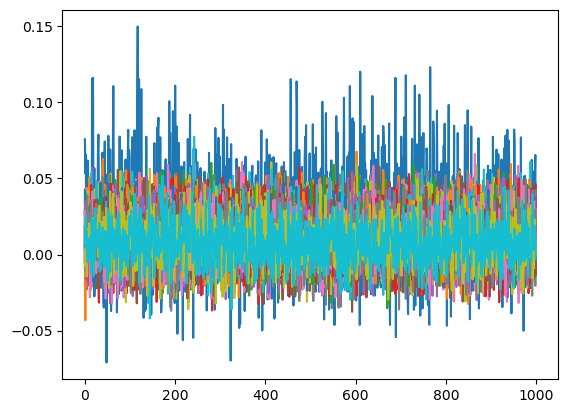

In [34]:
plt.plot(dummies)